In [1]:
%%bash
wget https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
unzip wikitext-2-v1.zip

--2023-11-19 16:34:58--  https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
Connecting to 10.44.2.90:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4475746 (4.3M) [application/zip]
Saving to: ‘wikitext-2-v1.zip.1’

     0K .......... .......... .......... .......... ..........  1%  199K 22s
    50K .......... .......... .......... .......... ..........  2%  111M 11s
   100K .......... .......... .......... .......... ..........  3%  396K 11s
   150K .......... .......... .......... .......... ..........  4% 84.3M 8s
   200K .......... .......... .......... .......... ..........  5%  131M 6s
   250K .......... .......... .......... .......... ..........  6% 5.43M 5s
   300K .......... .......... .......... .......... ..........  8%  430K 6s
   350K .......... .......... .......... .......... ..........  9% 58.2M 5s
   400K .......... .......... .......... .......... .......... 10% 91.6M 4s
   450K .......... .......... .......... .......

Archive:  wikitext-2-v1.zip


replace wikitext-2/wiki.test.tokens? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


CalledProcessError: Command 'b'wget https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip\nunzip wikitext-2-v1.zip\n'' returned non-zero exit status 1.

In [58]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader

from  torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import matplotlib.pyplot as plt
import seaborn as sns

from scripts.plot_loss import plot_losses
from scripts.train_model import train
from scripts.similiar import get_similar

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 14})

In [55]:
!ls scripts

plot_loss.py  __pycache__  similiar.py	train_model.py


In [51]:
TRAIN_TOKENS = 'wikitext-2/wiki.train.tokens'
VALID_TOKENS = 'wikitext-2/wiki.valid.tokens'

SKIPGRAM_N_WORDS = 4
MIN_WORD_FREQUENCY = 20
MAX_SEQUENCE_LENGTH = 256

EMBED_DIM = 256
EMBED_MAX_NORM = 1
BATCH_SIZE = 16
NUM_EPOCHS = 20

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [16]:
tokenizer = get_tokenizer("basic_english", language="en")

def load_and_preprocess_dataset(path):
    with open(path, 'r') as file:
        lines = file.readlines()

    data = list(filter(
        lambda sent: len(sent) > SKIPGRAM_N_WORDS * 2,
        map(tokenizer, lines)
    ))
    return data

In [17]:
train_data = load_and_preprocess_dataset(TRAIN_TOKENS)
valid_data = load_and_preprocess_dataset(VALID_TOKENS)

total_train_tokens = sum(len(sent) for sent in train_data)
total_valid_tokens = sum(len(sent) for sent in valid_data)

print(f'Num sentences: train - {len(train_data)}, valid - {len(valid_data)})')
print(f'Total tokens: train - {total_train_tokens}, valid - {total_valid_tokens})')
print(f'Average tokens in sentence: {total_train_tokens / len(train_data):.2f}')

Num sentences: train - 17715, valid - 1892)
Total tokens: train - 2014338, valid - 211057)
Average tokens in sentence: 113.71


In [23]:
vocab = build_vocab_from_iterator(train_data, specials=["<unk>"], min_freq=MIN_WORD_FREQUENCY)
vocab.set_default_index(vocab["<unk>"])

VOCAB_SIZE = len(vocab)
print(f'Vocab size: {VOCAB_SIZE}')

Vocab size: 8076


In [43]:
# vocab(['<unk>'])
# train_data[102]
# vocab(train_data[102])
vocab(['my', 'name', 'is','my', 'name', 'is', 'a'])

[452, 197, 22, 452, 197, 22, 8]

In [44]:
def collate_fn(batch):
    """
    Collate_fn for Skip-Gram model to be used with Dataloader.
    `batch` is expected to be list of text paragrahs.

    Context is represented as N=SKIPGRAM_N_WORDS past words 
    and N=SKIPGRAM_N_WORDS future words.

    Long paragraphs will be truncated to contain
    no more that MAX_SEQUENCE_LENGTH tokens.

    Each element in `batch_input` is a middle word.
    Each element in `batch_output` is a context word.
    """
    batch_input, batch_output = [], []
    for text in batch:
        text_tokens_ids = vocab(text)

        if MAX_SEQUENCE_LENGTH:
            text_tokens_ids = text_tokens_ids[:MAX_SEQUENCE_LENGTH]

        for idx in range(len(text_tokens_ids) - SKIPGRAM_N_WORDS * 2):
            token_id_sequence = text_tokens_ids[idx : (idx + SKIPGRAM_N_WORDS * 2 + 1)]
            input_ = token_id_sequence.pop(SKIPGRAM_N_WORDS)
            outputs = token_id_sequence

            batch_input += [input_] * len(outputs)
            batch_output += outputs

    batch_input = torch.tensor(batch_input, dtype=torch.long)
    batch_output = torch.tensor(batch_output, dtype=torch.long)
    return batch_input, batch_output

In [45]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=4,
                          pin_memory=True, collate_fn=collate_fn, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, num_workers=4,
                          pin_memory=True, collate_fn=collate_fn)

In [49]:
class Word2VecModel(nn.Module):
    def __init__(self, embed_dim, embed_max_norm, vocab_size):
        super().__init__()
        self.embeds = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim,
                                   max_norm=embed_max_norm)
        self.decoder = nn.Linear(embed_dim, vocab_size)
        
    def forward(self, tokens):
        embeds = self.embeds(tokens)
        logits = self.decoder(embeds)
        return logits

In [52]:
model = Word2VecModel(embed_dim=EMBED_DIM, embed_max_norm=EMBED_MAX_NORM,
                      vocab_size=VOCAB_SIZE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, NUM_EPOCHS)
criterion = nn.CrossEntropyLoss()

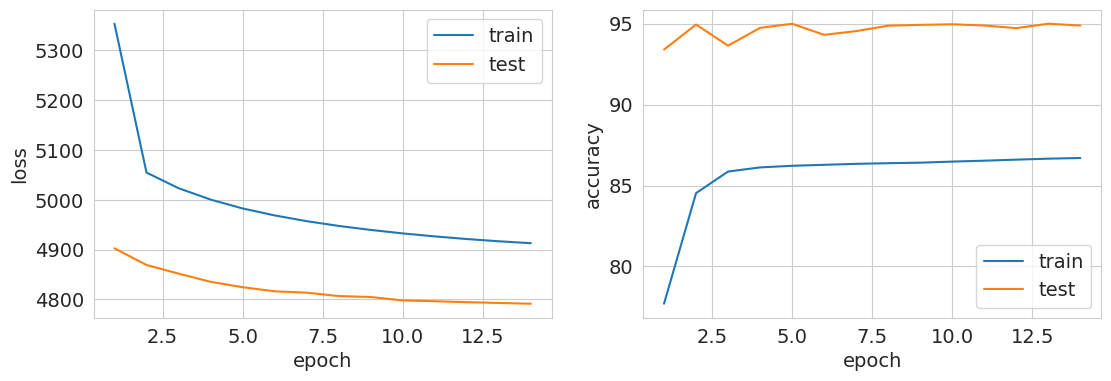

Training:  49%|██████████████▊               | 548/1108 [00:28<00:29, 18.90it/s]


KeyboardInterrupt: 

In [53]:
train(NUM_EPOCHS=NUM_EPOCHS, model=model, train_loader=train_loader, test_loader=valid_loader,
      optimizer=optimizer, scheduler=scheduler, criterion=criterion, device=device)

In [62]:
get_similar('woman')

Processing query "woman"
Found word "woman" in vocab
Top similar:
    woman: sim = 1.0000
    girl: sim = 0.8009
    man: sim = 0.7556
    lover: sim = 0.7481
    boyfriend: sim = 0.7434


### FastText for sentiment classification

In [63]:
%%bash
kaggle datasets download -d shivkumarganesh/bumble-dating-app-google-play-store-review
unzip bumble-dating-app-google-play-store-review.zip

Traceback (most recent call last):
  File "/home/vdimitrov/venv/bin/kaggle", line 33, in <module>
    sys.exit(load_entry_point('kaggle==1.5.16', 'console_scripts', 'kaggle')())
  File "/home/vdimitrov/venv/bin/kaggle", line 25, in importlib_load_entry_point
    return next(matches).load()
  File "/usr/lib/python3.10/importlib/metadata/__init__.py", line 171, in load
    module = import_module(match.group('module'))
  File "/usr/lib/python3.10/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1050, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 992, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 1050, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<fr

CalledProcessError: Command 'b'kaggle datasets download -d shivkumarganesh/bumble-dating-app-google-play-store-review\nunzip bumble-dating-app-google-play-store-review.zip\n'' returned non-zero exit status 9.